In [1]:
import matplotlib.pyplot as plt
import torch
from matplotlib.patches import Rectangle
from PIL import Image
from torchvision import transforms

from chestsearch.evaluation import scanpath_decode
from chestsearch.models import ExpertAttnTransformer
from common.config import JsonConfig

/home/ptthang/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# choose configs
TAP = "TP"  # ["TP", "TA", "FV"]

if TAP == "TP":
    # Target-present visual search (TP)
    hparams = JsonConfig("configs/finding_search_box_mask_max6_split_shuffled.json")


In [7]:
# create model
model = ExpertAttnTransformer(
    hparams.Data,
    num_decoder_layers=hparams.Model.n_dec_layers,
    hidden_dim=hparams.Model.embedding_dim,
    nhead=hparams.Model.n_heads,
    ntask=13,
    tgt_vocab_size=hparams.Data.patch_count + len(hparams.Data.special_symbols),
    num_output_layers=hparams.Model.num_output_layers,
    separate_fix_arch=hparams.Model.separate_fix_arch,
    train_encoder=hparams.Train.train_backbone,
    train_pixel_decoder=hparams.Train.train_pixel_decoder,
    use_dino=hparams.Train.use_dino_pretrained_model,
    dropout=hparams.Train.dropout,
    dim_feedforward=hparams.Model.hidden_dim,
    parallel_arch=hparams.Model.parallel_arch,
    dorsal_source=hparams.Model.dorsal_source,
    num_encoder_layers=hparams.Model.n_enc_layers,
    output_centermap="centermap_pred" in hparams.Train.losses,
    output_saliency="saliency_pred" in hparams.Train.losses,
    output_target_map="target_map_pred" in hparams.Train.losses,
    transfer_learning_setting=hparams.Train.transfer_learn,
    project_queries=hparams.Train.project_queries,
    is_pretraining=False,
    output_feature_map_name=hparams.Model.output_feature_map_name,
)

Config './configs/resnet50.yaml' has no VERSION. Assuming it to be compatible with latest v2.


Loaded backbone weights from ../checkpoints/M2F_R50.pkl
Loaded MSD pixel decoder weights from ../checkpoints/M2F_R50_MSDeformAttnPixelDecoder.pkl


In [8]:
# load checkpoint

checkpoint_pahts = {
    "TP": "../checkpoints/ckp_29999.pt",  # target present
}
ckpt = torch.load(checkpoint_pahts[hparams.Data.TAP], map_location="cpu")
ckpt_new = ckpt["model"].copy()
# for k, v in bb_weights.items():
#     if k[:3] == 'res':
#         bb_weights_new["stages." + k] = v
#         bb_weights_new.pop(k)
# Thang: not sure why but we need to revert this back to without "stages."
for k, v in ckpt["model"].items():
    if "encoder.backbone.stages." in k:
        ckpt_new[k.replace("encoder.backbone.stages.", "encoder.backbone.")] = v
        ckpt_new.pop(k)
model.load_state_dict(ckpt_new)

<All keys matched successfully>

(-0.5, 223.5, 223.5, -0.5)

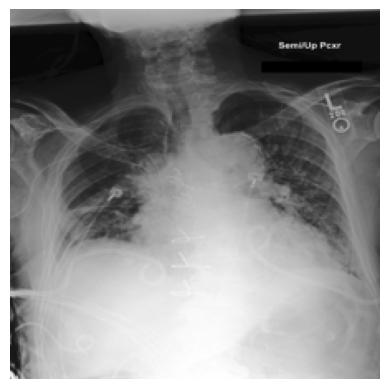

In [9]:
%matplotlib inline
# load test image
img = (
    Image.open(
        "../examples/0af38dfc-f95834b5-9074b060-f8389915-f10929a5.jpg"
    )
    .convert("RGB")
    .resize((224, 224))
)

plt.imshow(img)
plt.axis("off")

In [10]:
# preprocess
size = (hparams.Data.im_h, hparams.Data.im_w)
transform = transforms.Compose(
    [
        transforms.Resize(size=size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
img_tensor = torch.unsqueeze(transform(img), 0)

# Load preset task name and ids
preset_tasks = {
    "atelectasis": 0,
    "cardiomegaly": 1,
    "consolidation": 2,
    "edema": 3,
    "enlarged cardiomediastinum": 4,
    "fracture": 5,
    "lung lesion": 6,
    "lung opacity": 7,
    "pleural effusion": 8,
    "pleural other": 9,
    "pneumonia": 10,
    "pneumothorax": 11,
    "support devices": 12,
}

In [11]:
# utility functions
def plot_scanpath(img, xs, ys, bbox=None, title=None):
    fig, ax = plt.subplots()
    ax.imshow(img)
    cir_rad = 15

    for i in range(len(xs)):
        if i > 0:
            plt.arrow(
                xs[i - 1],
                ys[i - 1],
                xs[i] - xs[i - 1],
                ys[i] - ys[i - 1],
                width=3,
                color="yellow",
                alpha=0.5,
            )

    for i in range(len(xs)):
        circle = plt.Circle(
            (xs[i], ys[i]),
            radius=cir_rad,
            edgecolor="red",
            facecolor="yellow",
            alpha=0.5,
        )
        ax.add_patch(circle)
        plt.annotate(
            "{}".format(i + 1),
            xy=(xs[i], ys[i] + 3),
            fontsize=10,
            ha="center",
            va="center",
        )

    if bbox is not None:
        rect = Rectangle(
            (bbox[0], bbox[1]),
            bbox[2],
            bbox[3],
            alpha=0.5,
            edgecolor="yellow",
            facecolor="none",
            linewidth=2,
        )
        ax.add_patch(rect)

    ax.axis("off")
    if title is not None:
        ax.set_title(title)
    plt.show()


def actions2scanpaths(norm_fixs, im_h, im_w):
    # convert actions to scanpaths
    scanpaths = []
    for fixs in norm_fixs:
        fixs = fixs.numpy()
        scanpaths.append(
            {
                "X": fixs[:, 0] * im_w,
                "Y": fixs[:, 1] * im_h,
            }
        )
    return scanpaths

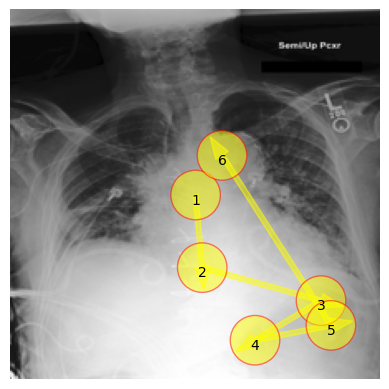

In [18]:
task = "cardiomegaly"
# task = "atelectasis"
task = "pneumonia"
# task = "edema"
sample_action = False
task_id = torch.tensor([preset_tasks[task]], dtype=torch.long)
normalized_sp, _ = scanpath_decode(
    model,
    img_tensor,
    task_id,
    hparams.Data,
    sample_action=sample_action,
    center_initial=True,
)
scanpath = actions2scanpaths(normalized_sp, hparams.Data.im_h, hparams.Data.im_w)[0]

plot_scanpath(img, scanpath["X"], scanpath["Y"])